In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")

C:\Users\Paolo\AppData\Local\Temp\ipykernel_12528\4264980074.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
# WITH OANDA
import tpqoa
api = tpqoa.tpqoa("oandaMY.cfg")

In [3]:
# WITH IBKR
# ib.disconnect()
import pandas as pd
from ib_insync import *
util.startLoop()  # not necessary in scripts
ib = IB()
ib.connect()

<IB connected to 127.0.0.1:7497 clientId=1>

In [4]:
class SMABacktester():
    ''' Classe per il backtesting di strategie SMA'''
    
    def __init__(self, symbol, SMA_s, SMA_l, start, end):
        '''
        Parametri
        ---------
        symbol: str
            simbolo del ticker per OANDA
        SMA_s: int
            finestra corta
        SMA_l: int
            finestra lunga
        start: str
            data di inizio
        end: str
            data di fine
        '''
        self.symbol = symbol
        self.SMA_s = SMA_s
        self.SMA_l = SMA_l
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_s = {}, SMA_l = {}, start = {}, end = {})".format(self.symbol,self.SMA_s,
                                                                                self.SMA_l,self.start,self.end)
        
# # WITH OANDA
#     def get_data(self): # carica i dati
#         df = api.get_history(instrument = self.symbol, start = self.start, end = self.end, 
#                              granularity = "D", price = "M")["c"].to_frame()
#         df.rename(columns={"o":"open","h":"high","l":"low","c":"close","time":"date"},inplace=True)
#         df.index.names = ['date']
#         df["logRet"]=np.log(df/df.shift(1))
#         self.data=df.dropna()

# WITH IBKR
    def get_data(self): # carica i dati
        df = pd.DataFrame(ib.reqHistoricalData( self.symbol, endDateTime = self.end, 
                                  barSizeSetting="1 day", durationStr=self.start, 
                                  whatToShow= "MIDPOINT", useRTH = True, formatDate=2 )).set_index("date")
        df.index=pd.to_datetime(df.index)
        df = df.close.to_frame()
        df["logRet"]=np.log(df/df.shift(1))
        self.data=df.dropna()
    
    def prepare_data(self): # contruisce il dataframe internamente 
        self.data["SMA_s"]=self.data["close"].rolling(self.SMA_s).mean()
        self.data["SMA_l"]=self.data["close"].rolling(self.SMA_l).mean()
        # return self.data
    
    def set_parameters(self, SMA_s=None, SMA_l=None):
        if SMA_s is not None:
            self.SMA_s = SMA_s
            self.data["SMA_s"]=self.data["close"].rolling(SMA_s).mean()
        if SMA_l is not None:
            self.SMA_l = SMA_l
            self.data["SMA_l"]=self.data["close"].rolling(SMA_l).mean()

    def test_strategy(self):
        data=self.data.copy()
        data.dropna(inplace=True)
        data["posizione"]=np.where(data.SMA_s>data.SMA_l,+1,-1)
        data["strategia"]= data.posizione.shift(1) * data.logRet
        data.dropna(inplace=True)
        data["cumLogRet"]= data.logRet.cumsum()
        data["cumStrategia"]= data.strategia.cumsum()
        # performance = np.exp(data.cumStrategia.iloc[-1])
        # outPerformance = performance - np.exp(data.cumLogRet.iloc[-1])
        performance = data.cumStrategia.iloc[-1]
        outPerformance = performance - data.cumLogRet.iloc[-1]
        maxDrawdown=(data.strategia.cumsum().cummax()-data.strategia.cumsum()).max()
        self._results=data
        return round(performance,6),round(outPerformance,6),round(maxDrawdown,6)
    
    def plot_results(self):
        if self._results is None:
            print("Devi prima chiamare test_strategy()")
        else:
            titolo="{}    SMA_S = {}     SMA_L = {}".format(self.symbol,self.SMA_s,self.SMA_l)
            self._results[["cumLogRet","cumStrategia"]].plot(figsize=(25,15))
            plt.legend(fontsize=18)
            plt.title(titolo,fontsize=22)
    
    def optimize_parameters(self, SMA_s_range, SMA_l_range): # ranges are tuples
        ''' Trova la stretgia ottimale all\'interno dei range dei parametri indicati
        
        Parametri
        ---------
        SMA_s_range: tuple di 2 o 3 int
            inizio e fine (e eventualmente step) del range per la finestra corta
        SMA_l_range: tuple di 2 o 3 int
            inizio e fine (e eventualmente step) del range per la finestra corta
        '''
        
        combinazioni = list(product(range(SMA_s_range[0],SMA_s_range[1]),range(SMA_l_range[0],SMA_l_range[1]) ))
        # combinazioni = list(product(range(*SMA_s_range),range(*SMA_l_range) ))
        risultati= []
        for comb in combinazioni:
            self.set_parameters(comb[0],comb[1])
            risultati.append(self.test_strategy()[0])
        
        best_performance = np.max(risultati)
        best_combinazione = combinazioni[np.argmax(risultati)]
        
        # eseguiamo la strategia migliore
        self.set_parameters(best_combinazione[0],best_combinazione[1])
        self.test_strategy()
        
        # mettiamo i risulati in un bel dataframe
        AllResults = pd.DataFrame(combinazioni, columns=["SMA_s","SMA_l"])
        AllResults["performance"]= risultati
        self.results_overview = AllResults
        
        return best_combinazione, best_performance
    

In [5]:
# WITH OANDA 
# tester = SMABacktester("EUR_USD",50,200,"2011-09-24","2023-09-24")
# WITH IBKR
trainer = SMABacktester(Forex("EURUSD"),50,200,"12 Y","20230924 00:00:00")

In [6]:
trainer.data.head(55)

close    logRet     SMA_s  SMA_l
date                                          
2011-09-27  1.35835  0.003725       NaN    NaN
2011-09-28  1.35420 -0.003060       NaN    NaN
2011-09-29  1.35970  0.004053       NaN    NaN
2011-09-30  1.33880 -0.015490       NaN    NaN
2011-10-03  1.31770 -0.015886       NaN    NaN
2011-10-04  1.33490  0.012969       NaN    NaN
2011-10-05  1.33480 -0.000075       NaN    NaN
2011-10-06  1.34375  0.006683       NaN    NaN
2011-10-07  1.33775 -0.004475       NaN    NaN
2011-10-10  1.36425  0.019616       NaN    NaN
2011-10-11  1.36395 -0.000220       NaN    NaN
2011-10-12  1.37920  0.011119       NaN    NaN
2011-10-13  1.37775 -0.001052       NaN    NaN
2011-10-14  1.38825  0.007592       NaN    NaN
2011-10-17  1.37375 -0.010500       NaN    NaN
2011-10-18  1.37520  0.001055       NaN    NaN
2011-10-19  1.37605  0.000618       NaN    NaN
2011-10-20  1.37800  0.001416       NaN    NaN
2011-10-21  1.38965  0.008419       NaN    NaN
2011-10-24  1.39290  0.002336       NaN    NaN
2011-10-25  1.39080 -0.001509       NaN    NaN
2011-10-26  1.39065 -0.000108       NaN    NaN
2011-10-27  1.41890  0.020111       NaN    NaN
2011-10-28  1.41475 -0.002929       NaN    NaN
2011-10-31  1.38575 -0.020711       NaN    NaN
2011-11-01  1.37035 -0.011175       NaN    NaN
2011-11-02  1.37475  0.003206       NaN    NaN
2011-11-03  1.38230  0.005477       NaN    NaN
2011-11-04  1.37915 -0.002281       NaN    NaN
2011-11-07  1.37765 -0.001088       NaN    NaN
2011-11-08  1.38340  0.004165       NaN    NaN
2011-11-09  1.35425 -0.021296       NaN    NaN
2011-11-10  1.36065  0.004715       NaN    NaN
2011-11-11  1.37495  0.010455       NaN    NaN
2011-11-14  1.36330 -0.008509       NaN    NaN
2011-11-15  1.35395 -0.006882       NaN    NaN
2011-11-16  1.34635 -0.005629       NaN    NaN
2011-11-17  1.34580 -0.000409       NaN    NaN
2011-11-18  1.35250  0.004966       NaN    NaN
2011-11-21  1.34895 -0.002628       NaN    NaN
2011-11-22  1.35055  0.001185       NaN    NaN
2011-11-23  1.33425 -0.012143       NaN    NaN
2011-11-24  1.33470  0.000337       NaN    NaN
2011-11-25  1.32385 -0.008162       NaN    NaN
2011-11-28  1.33195  0.006100       NaN    NaN
2011-11-29  1.33165 -0.000225       NaN    NaN
2011-11-30  1.34460  0.009678       NaN    NaN
2011-12-01  1.34615  0.001152       NaN    NaN
2011-12-02  1.33925 -0.005139       NaN    NaN
2011-12-05  1.34010  0.000634  1.361702    NaN
2011-12-06  1.34010  0.000000  1.361337    NaN
2011-12-07  1.34120  0.000820  1.361077    NaN
2011-12-08  1.33410 -0.005308  1.360565    NaN
2011-12-09  1.33870  0.003442  1.360563    NaN
2011-12-12  1.31880 -0.014977  1.360585    NaN

In [7]:
trainer.optimize_parameters((30,90), (100,200))

((88, 115), 0.645511)

In [8]:
trainer.test_strategy() # attenzione che è su 11 anni

(0.645511, 0.860891, 0.130265)

In [9]:
# WITH OANDA 
# tester = SMABacktester("EUR_USD",85,122,"2013-09-24","2024-09-24")
# WITH IBKR
tester = SMABacktester(Forex("EURUSD"),85,122,"1 Y","20240924 00:00:00")

In [10]:
tester.test_strategy() # questo invece è solo su 1 anni

(-0.031853, -0.059744, 0.051538)

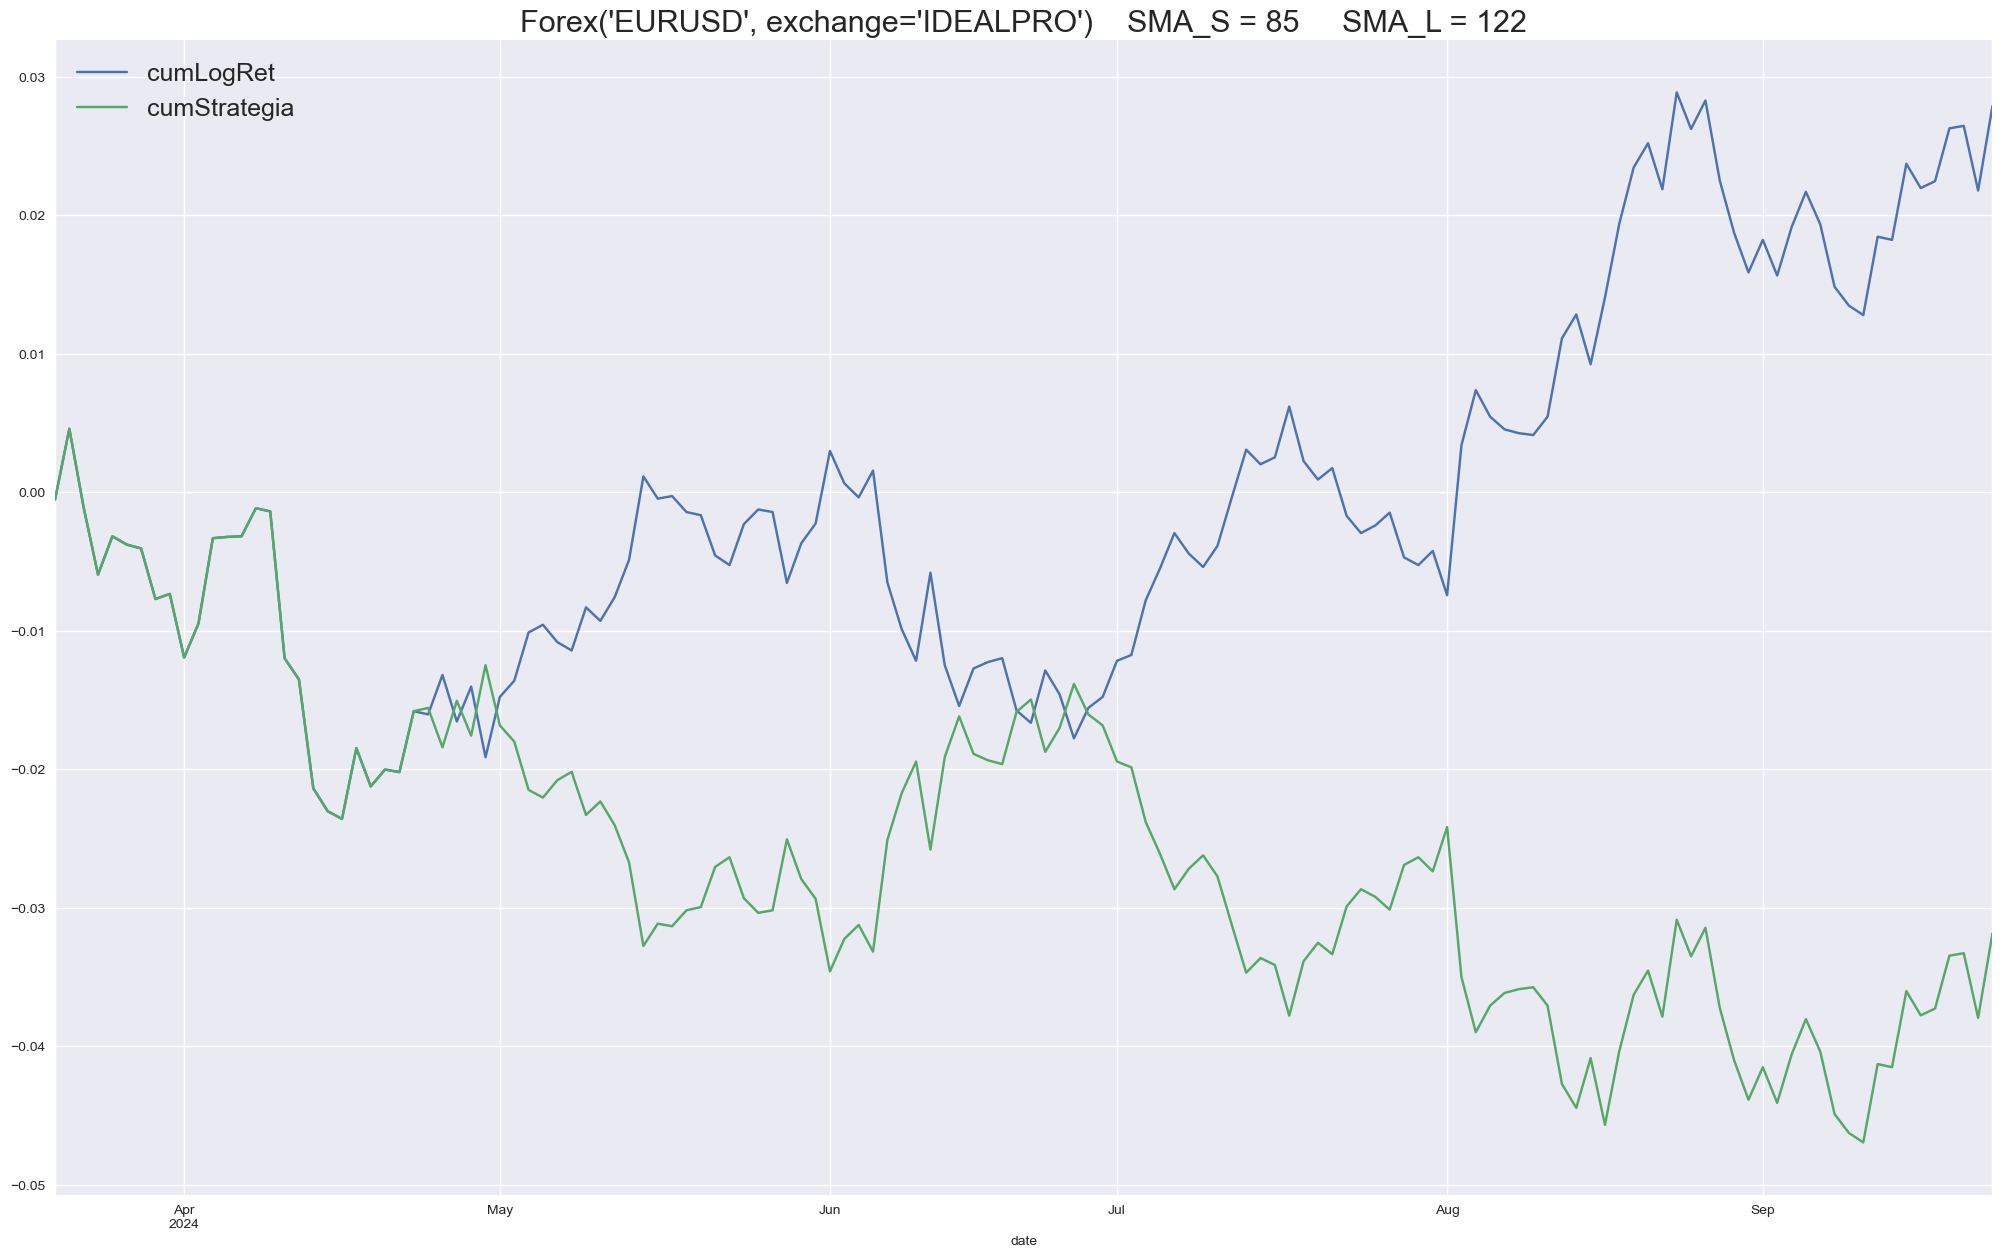

In [11]:
tester.plot_results()

In [29]:
ib.qualifyContracts(Forex("GBPUSD"))

[Forex('GBPUSD', conId=12087797, exchange='IDEALPRO', localSymbol='GBP.USD', tradingClass='GBP.USD')]

In [30]:
ib.reqHeadTimeStamp( Forex("GBPUSD"), whatToShow= "MIDPOINT", useRTH = True )

datetime.datetime(2005, 3, 9, 4, 30)

In [38]:
# WITH OANDA 
# tester = SMABacktester("GBP_USD",85,122,"2022-09-24","2023-09-24")
# WITH IBKR
tester = SMABacktester(Forex("GBPUSD"),85,122,"1 Y","20230924 00:00:00")
tester.test_strategy()

(0.015105, 0.0, 0.070647)

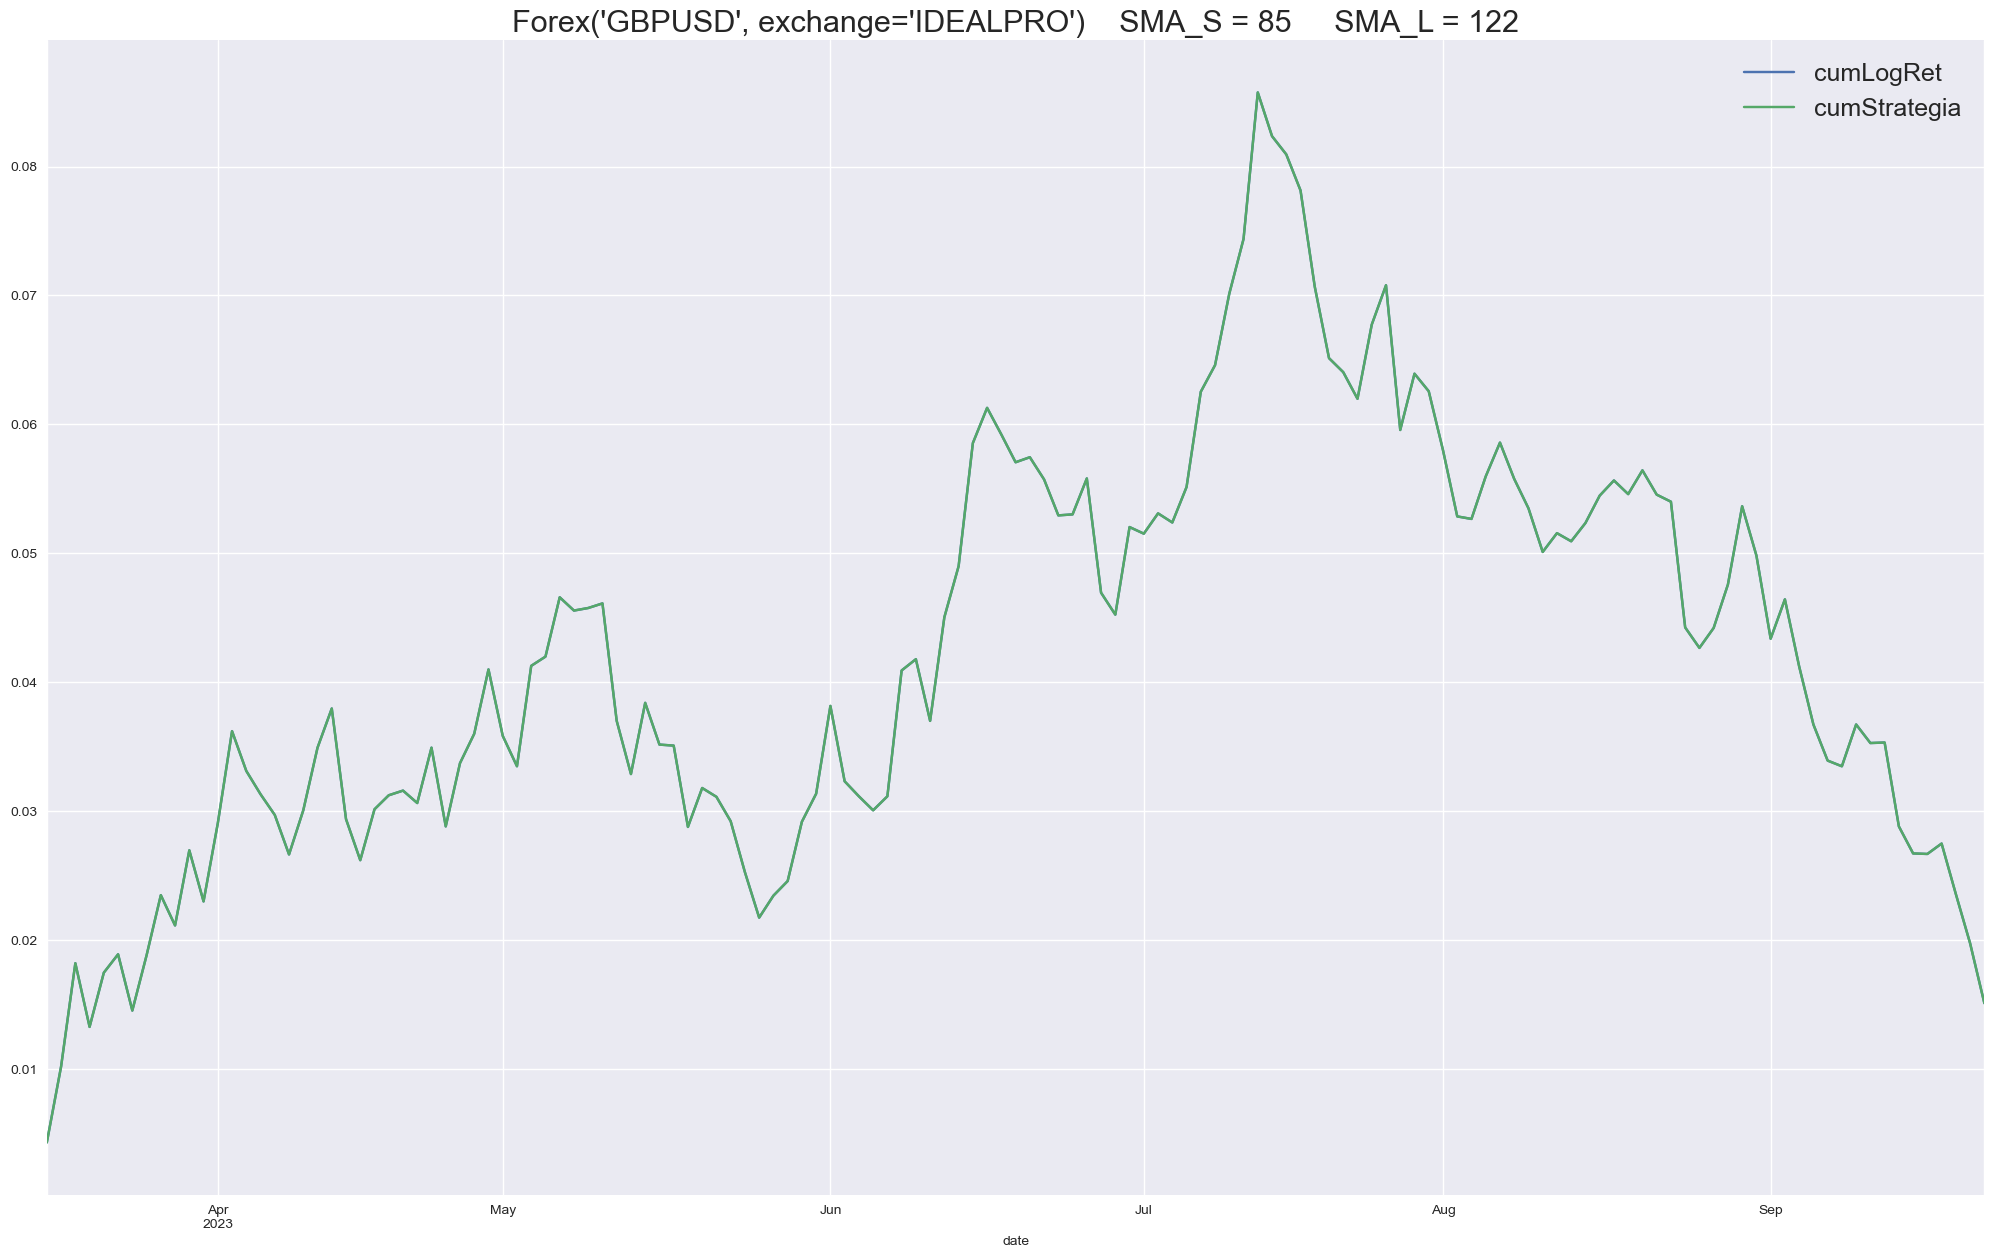

In [39]:
tester.plot_results()

In [40]:
ib.disconnect()